In [43]:
# First, we read in the file and import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as cmatrix


In [44]:
from keras.datasets import mnist

#Load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [45]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [46]:
# let's do a first UMAP feature etraction 
# and dimensionaliy reduction

# Reshape the 28x28 pixel images into a single 784px vector using .reshape
x_train = np.reshape(x_train, (len(x_train), -1))
x_test = np.reshape(x_test, (len(x_test), -1))

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [47]:
x_train = x_train / 255

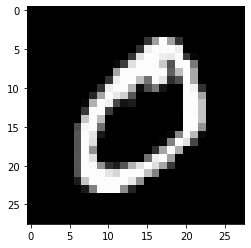

In [48]:
image = x_train[1].reshape(28,28)
plt.imshow(image, cmap='gray')

In [96]:
np.random.seed(10)

random_indices = np.random.choice(60000, size=6000, replace=False)
random_x_train = x_train[random_indices, :]
random_y_train = y_train[random_indices]

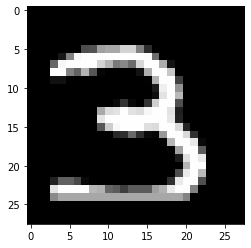

In [97]:
image = random_x_train[0].reshape(28,28)
plt.imshow(image, cmap='gray')

In [161]:
random_x_train[0].reshape(1,-1).reshape(-1).shape

(784,)

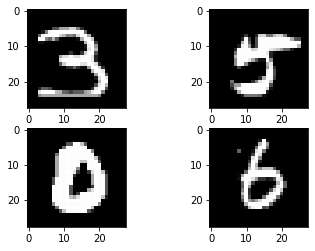

In [98]:
f, ax = plt.subplots(2,2)
ax[0,0].imshow(random_x_train[0].reshape(28,28), cmap='gray')
ax[0,1].imshow(random_x_train[1].reshape(28,28), cmap='gray')
ax[1,0].imshow(random_x_train[2].reshape(28,28), cmap='gray')
ax[1,1].imshow(random_x_train[3].reshape(28,28), cmap='gray')
plt.show()

In [162]:
np.shape(random_x_train), np.shape(random_y_train)

((6000, 784), (6000,))

In [102]:
import umap

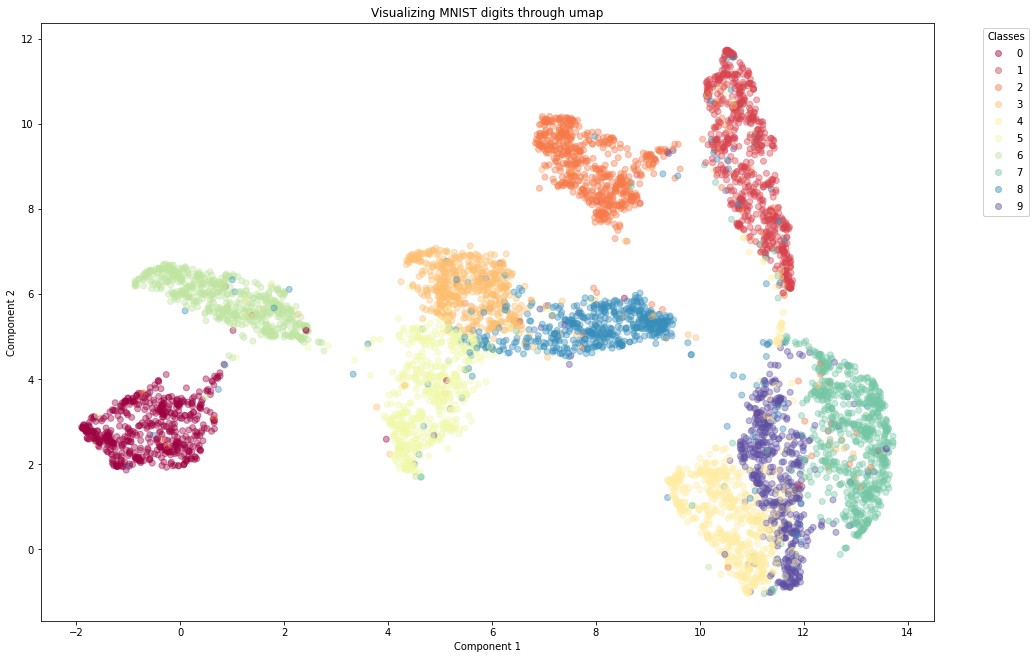

In [103]:
# run UMAP with 2 dimensions
mapper = umap.UMAP(n_components=2, random_state=40).fit(random_x_train)
umap_components = mapper.transform(random_x_train)


# create the scatter plot
fig, ax = plt.subplots(figsize=(16,11))
scatter = ax.scatter(
    x=umap_components[:,0], 
    y=umap_components[:,1], 
    c=random_y_train, 
    cmap=plt.cm.get_cmap('Spectral'), 
    alpha=0.4)



# produce a legend with the colors from the scatter
legend = ax.legend(*scatter.legend_elements(), title="Classes",bbox_to_anchor=(1.05, 1), loc='upper left',)
ax.add_artist(legend)
ax.set_title("Visualizing MNIST digits through umap")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [104]:
umap_components.shape, random_y_train.shape

((6000, 2), (6000,))

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [106]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [107]:
# now let's do it for all digits!

KDE_sample_dict = {}
KDE_models = []

for digit in range(0,10):
    # get the x-data points for each digit along with the y-labels 
    digit_indices = np.where(random_y_train==digit)
    umap_digit_components = umap_components[digit_indices]
    random_y_train_digit = random_y_train[digit_indices]
    
    # then use grid search to find good parameters
    params = {'bandwidth': np.logspace(-2, 1, 100)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, n_jobs=-1)
    grid.fit(umap_digit_components) 
    
    # then fit the KDE on bandwith
    optimal = grid.best_params_['bandwidth']
    KDE_digit = KernelDensity(kernel='gaussian', bandwidth=optimal)
    KDE_digit.fit(umap_digit_components)
    KDE_models.append(KDE_digit)
    
    # resample from the KDE
    # this will have 2 components (the UMAP components)
    KDE_sampled_digits = KDE_digit.sample(n_samples=umap_digit_components.shape[0])
    
    KDE_sample_dict[str(digit)] = (KDE_sampled_digits, random_y_train_digit)

In [108]:
umap_image_points_set = []
for i in range(0,10):
    points = KDE_sample_dict[str(i)][0]
    umap_image_points_set.append(points)
    
sampled_dataset_points = np.vstack(tuple(umap_image_points_set))

In [109]:
umap_image_labels = []
for i in range(0,10):
    labels = KDE_sample_dict[str(i)][1]
    umap_image_labels.append(labels)
    
sampled_dataset_labels = np.hstack(tuple(umap_image_labels))
sampled_dataset_labels.shape, sampled_dataset_points.shape

((6000,), (6000, 2))

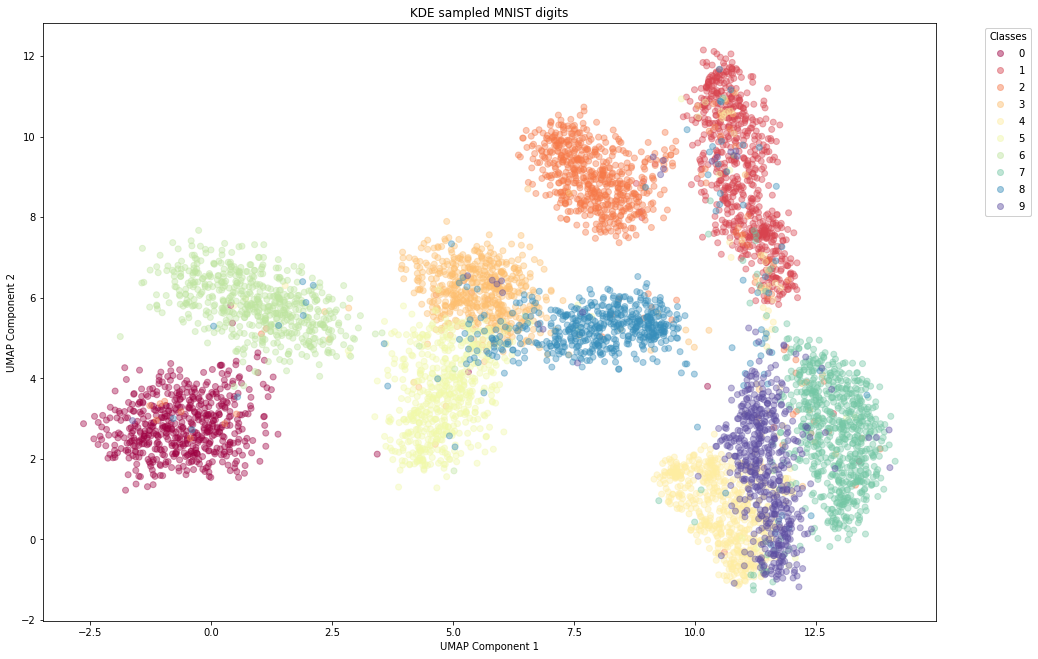

In [110]:
# create the scatter plot
fig, ax = plt.subplots(figsize=(16,11))
scatter = ax.scatter(
    x=sampled_dataset_points[:,0], 
    y=sampled_dataset_points[:,1], 
    c=sampled_dataset_labels, 
    cmap=plt.cm.get_cmap('Spectral'), 
    alpha=0.4)



# produce a legend with the colors from the scatter
legend = ax.legend(*scatter.legend_elements(), title="Classes",bbox_to_anchor=(1.05, 1), loc='upper left',)
ax.add_artist(legend)
ax.set_title("KDE sampled MNIST digits")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [137]:
KDE_digit_models = {str(i):m for (i,m) in enumerate(KDE_models)}
KDE_digit_models

{'0': KernelDensity(bandwidth=0.4037017258596556),
 '1': KernelDensity(bandwidth=0.23101297000831603),
 '2': KernelDensity(bandwidth=0.2848035868435802),
 '3': KernelDensity(bandwidth=0.30538555088334157),
 '4': KernelDensity(bandwidth=0.14174741629268056),
 '5': KernelDensity(bandwidth=0.32745491628777285),
 '6': KernelDensity(bandwidth=0.464158883361278),
 '7': KernelDensity(bandwidth=0.21544346900318845),
 '8': KernelDensity(bandwidth=0.26560877829466867),
 '9': KernelDensity(bandwidth=0.21544346900318845)}

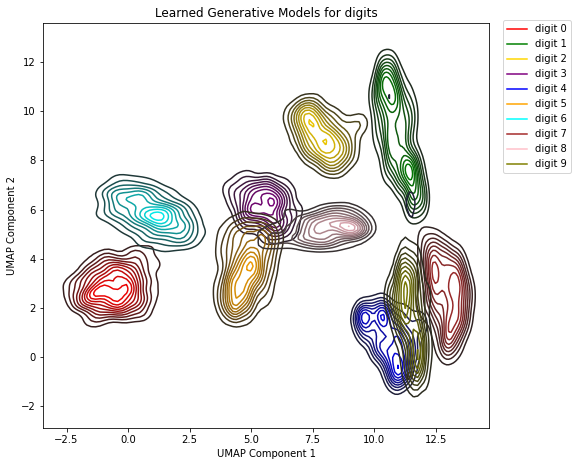

In [131]:
color_dict = {0:'red', 1:'green', 2:'gold', 3:'purple', 4:'blue', 
              5:'orange', 6:'cyan', 7:'brown', 8:'pink', 9:'olive'}

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")



for (k,col) in color_dict.items():
    ax = sns.kdeplot(data=KDE_sample_dict[str(k)][0].squeeze(),ax=ax,
                     color=color_dict[k], label='digit {}'.format(k))

ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')




plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('Learned Generative Models for digits')
plt.show()


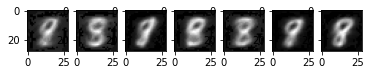

In [174]:
# generating new sample images from the learned generative "mental" models

def generate_digit(digit, n_samples):
    #generate the data points
    model = KDE_digit_models[str(digit)]
    samples = model.sample(n_samples=n_samples)
    image_vectors = [mapper.inverse_transform(samples[k,:].reshape(1, -1)).reshape(-1) 
                     for k in range(n_samples)]

    # plot the point as an image
    fig, ax = plt.subplots(1,n_samples)

    for i in range(n_samples):
        ax[i].imshow(image_vectors[i].reshape(28,28), cmap='gray')
    plt.show()


    
generate_digit(digit=8, n_samples=7)


In [139]:
def decision(sample, models):
    #reformat the sample
    sample = sample.reshape(1,-1)
    # umap transform the sample
    umap_transformed_sample = mapper.transform(sample)
    log_likelihoods = [M.score_samples(umap_transformed_sample)
                      for M in models.values()]    
    # sort the likelihoods from  low to high
    pairs = sorted(list(zip(log_likelihoods, range(0,10))), key=lambda x:x[0])
    # top 1st choice
    first = pairs[-1][0]
    # top 2nd choice
    second = pairs[-2][0]
    likelihood_ratio = np.exp(first-second)
    if likelihood_ratio <= 3.0:
        print("There's very little evidence that my first choice, digit {0} is more correct than my second choice, digit {1}.".format(pairs[-1][1], likelihood_ratio, pairs[-2][1]))
        return 'I refuse to decide!'.format(pairs[-1][1], pairs[-2][1])
    elif (likelihood_ratio > 4.0) and (likelihood_ratio <= 10.0):
        print("There is a bit of evidence that my first choice, digit {0} is more correct than my second choice, digit {1}.".format(pairs[-1][1], pairs[-2][1]))
        return 'maybe digit {0} over {1}'.format(pairs[-1][1], pairs[-2][1])
    else:
        print('There is strong evidence that my first choice, digit {0} is more correct than my second choice, digit {1}.'.format(pairs[-1][1], pairs[-2][1]))
        return pairs[-1][1]    

In [147]:
import random

In [148]:
random_index = random.randint(0, len(x_train)-1) 
S = x_train[random_index]

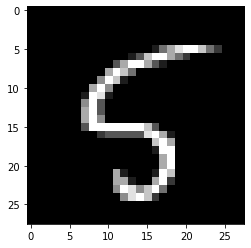

In [149]:
plt.imshow(S.reshape(28,28), cmap='gray')
plt.show()

In [150]:
decision(sample=S, models=KDE_digit_models)

There is strong evidence that my first choice, digit 5 is more correct than my second choice, digit 8.


5

In [ ]:
# here is a potential class OOP-implementation of this generative classifier

from time import sleep

# for mnist classifier, data=mnist.load_data() (for the constructor method)

class MNISTClassifier:
    
    def __init__(self, data, y):
        self.data = data
        self.y = y
        self.categories = np.unique(y)
        
        
    def setup_data(self, k_samples=9000):
        (x_train, x_test) = self.data 
        (y_train, y_test) = self.y
        x_train = np.reshape(x_train, (len(x_train), -1))
        x_test = np.reshape(x_test, (len(x_test), -1))
        # randomly sample from x_train and y_train
        # this random sample with fixed data size will be the actual training set we use
        np.random.seed(15)
        random_indices = np.random.choice(60000, size=k_samples, replace=False)
        random_x_train = x_train[random_indices, :]
        random_y_train = y_train[random_indices]
        self.X_train = random_x_train
        self.Y_train = random_y_train
        
        
    def fit(self):
        # first find the UMAP components for all the images
        # then put the mapper into a classs-Instance
        self.mapper = umap.UMAP(n_components=2, random_state=40).fit(self.data)
        # now start transforming!
        umap_components = self.mapper.transform(self.data)
        self.umap_components = umap_components
        density_models = []
        # now train the density generative models for each category
        for cat in self.categories:
            # get the x-data points for each digit along with the y-labels 
            category_indices = np.where(random_y_train==cat)
            umap_category_components = umap_components[category_indices]
            # then use grid search to find good density estimation parameters
            params = {'bandwidth': np.logspace(-2, 1, 100)}
            grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, n_jobs=-1)
            grid.fit(umap_category_components) 
            # then fit the KDE density with the optimal bandwith
            optimal = grid.best_params_['bandwidth']
            KDE = KernelDensity(kernel='gaussian', bandwidth=optimal)
            KDE.fit(umap_category_components)
            density_models.append(KDE)
            
        # put the density models into a Instance dictionary variable
        self.model_dict = {str(i):m for (i,m) in enumerate(density_models)}
         
            
    def visualize_models(self):
        color_dict = {0:'red', 1:'green', 2:'gold', 3:'purple', 4:'blue', 
                      5:'orange', 6:'cyan', 7:'brown', 8:'pink', 9:'olive'}
        
        f, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect("equal")
        
        for (k,col) in color_dict.items():
            ax = sns.kdeplot(data=KDE_sample_dict[str(k)][0].squeeze(),ax=ax,
                             color=color_dict[k], label='digit {}'.format(k))
            
        ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.title('Learned Generative Models for digits')
        plt.show()
          
        
    def decision(sample, models):
        # umap transform the sample
        umap_transformed_sample = self.mapper.transform(sample)
        # calculate the model likelihood of the sample from each density model
        log_likelihoods = []
        for M in models:
            value = M.score_samples(umap_transformed_sample)
            log_likelihoods.append(value)
            
        # set up the priors
        priors = pd.Series.sort_index(pd.Series(self.Y_train).value_counts(normalize=True))
        # calculate the un-normalized log bayes posterior
        log_unn_posteriors = np.add(np.asarray(log_likelihoods), np.asarray(priors))
        # normalize the posteriors
        log_posteriors = log_unn_posteriors/np.sum(log_unn_posteriors)
        # sort the un-normalized posteriors from low to high
        pairs = sorted(list(zip(log_posteriors, range(0,10))), key=lambda x:x[0])
        # top 1st choice, top 2nd choice
        first, second = pairs[-1][0], pairs[-2][0]
        # posterior ratio
        posterior_ratio = np.exp(first-second)
        
        # ask user if they want a decision/prediction or probabilities
        user_answer = input("Do you want a decision/prediction or probabilities? ")
        
        
        # make the decision!
        if (posterior_ratio <= 3.0):
            print("There's very little evidence that my first choice, digit {0} is more correct than my second choice, digit {1}."
                  .format(pairs[-1][1], likelihood_ratio, pairs[-2][1]))
            print("I refuse to decide!")
            
        elif ((posterior_ratio > 3.0) and (posterior_ratio <= 10.0)):
            print("There is a bit of evidence that my first choice, digit {0} is more correct than my second choice, digit {1}."
                  .format(pairs[-1][1], pairs[-2][1]))
            return pairs[-1][1]
        else:
            print('There is strong evidence that my first choice, digit {0} is more correct than my second choice, digit {1}.'
                  .format(pairs[-1][1], pairs[-2][1]))
            return pairs[-1][1]
        
    
    def ask_machine(self, predicted, actual):
        # Machine will say "hey! Was my prediction correct?"
        print("Hi user! Was my prediction for the sample correct?")
        user_answer = input('Answer: ')
        
        if any(['yes' in user_answer, 'correct' in user_answer, 'yep' in user_answer]):
            print('Yay!')
            
        elif any(['no' in user_answer, 'incorrect' in user_answer, 'nope' in user_answer, 'wrong' in user_answer]):
            print('Oh no!')
            user_answer2 = input('Ask the machine: ')
            if any(['Why' in user_answer2, 'mistake' in user_answer2, 'wrong' in user_answer2]):
                computer_ans = 'The reason I predicted {0} instead of {1} among my top 2 choices is because'+' '+'the likelihood of the sample under my mental density model of {0}'+' '+'was much higher than the likelihood under my density model of {1}'
                computer_ans.format(predicted, actual)
            sleep(1.0)   
            print('Since I got it incorrect and my decision block was pure logic, not statistical.', 'That means either 2 things:' 
                  'either my mental models (the density distributions I learned) are incorrect,'
                  'or the feature extraction mapping was incorrect, or both were wrong.')
            sleep(1.0)
            print('Would you like to see my density models, feature mapping, or both?')
            user_answer3 = input('Answer: ')
            
            
            
        
        
        
       